# 过拟合overfitting
通俗点说法，过拟合就是在训练集下的表现过于优越，导致在验证集或在测试集上的表现不佳。<br>
在神经网络中，有一个普遍的现象可以说明是出现了过拟合，当val_loss达到一个最低值的时候突然回升，val_loss不断升高。<br>
以下，我们针对这一现象来提出一些入门级的解决方法。<br>

In [1]:
# 导入数据集
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [2]:
(train_data, train_labels), (test_data, test_data) = mnist.load_data()

In [4]:
train_data.shape

(60000, 28, 28)

In [6]:
# reshape, 
# 数据预处理，归一化
train_data = train_data.reshape((60000, 28*28))
train_data = train_data.astype("float32") / 255.

# one-hot
train_labels = to_categorical(train_labels)

In [10]:
# split
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, random_state=42, test_size=0.3) 

## Method-1. 降低模型的复杂性
最简单避免过拟合的方法可能是降低模型的复杂性了：<br>
* 减少参数数量即减少神经元的数量。
* 或者减少网络的层数。
* 有一种说法，当模型的参数越大，层数越深的话，即代表该网络的能力(capacity)越好。即可以更容易地从训练集中获取一种样本到目标的映射关系，并且是非常严格的映射关系。如果样本或者特征稍微有一些变化，则会出错。<br>
* 因此，这样的模型是不具有泛化能力的，鲁棒性差，在真实场景上的数据分布不具备就好的预测能力。
* 相反，如果一个模型的能力有限，无法轻易的从数据上获取以上所说的映射能力，但是为了降低loss，模型会学到一种具有更一般性的预测能力。

In [12]:
from keras.models import Sequential
from keras.layers import Dense

In [60]:
# 原始模型，复杂度更高的模型
ori_model = Sequential()
ori_model.add(Dense(128, activation='relu', input_shape=(28*28, )))
ori_model.add(Dense(128, activation='relu'))
ori_model.add(Dense(10, activation='softmax'))

ori_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

sim_model = Sequential()
sim_model.add(Dense(64, activation='relu', input_shape=(28*28, )))
sim_model.add(Dense(10, activation='softmax'))

sim_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
ori_his = ori_model.fit(x=X_train, y=y_train, batch_size=256, epochs=40, validation_data=(X_val, y_val), verbose=0)
sim_his = sim_model.fit(x=X_train, y=y_train, batch_size=256, epochs=40, validation_data=(X_val, y_val), verbose=0)

In [62]:
ori_val_Loss = ori_his.history['val_loss']
sim_val_Loss = sim_his.history['val_loss']

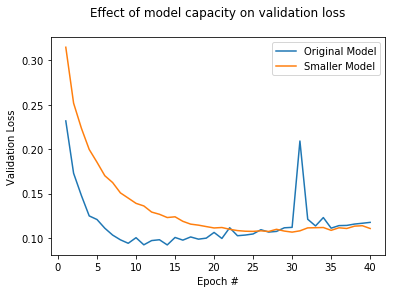

In [63]:
# 绘图
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(40) + 1
plt.plot(epochs, ori_val_Loss, label='Original Model')
plt.plot(epochs, sim_val_Loss, label='Smaller Model')
plt.title("Effect of model capacity on validation loss\n")
plt.xlabel('Epoch #')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

从上图可以看出，更小的网络更具有平缓的loss下降趋势，而更大的网络，会更早的过拟合。<br>
** 注意：** 以上例子仅仅是为了说明，而并非说网络更小的更好，而是还要看具体场景，不同场景，可能更深的网络会表现的更好，并且不会过拟合。<br>

## Method-2. 添加正则项
在之前讨论特征过程的时候，就说过，添加正则项有利于降低过拟合的程度。

In [64]:
from keras import regularizers

In [84]:
ori_model = Sequential()
ori_model.add(Dense(64, activation='relu', input_shape=(28*28, )))
ori_model.add(Dense(64, activation='relu'))
ori_model.add(Dense(10, activation='softmax'))

ori_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

re_model = Sequential()
re_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01), input_shape=(28*28, )))
re_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
re_model.add(Dense(10, activation='softmax'))

re_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
ori_his = ori_model.fit(x=X_train, y=y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), verbose=0)
re_his = sim_model.fit(x=X_train, y=y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), verbose=0)

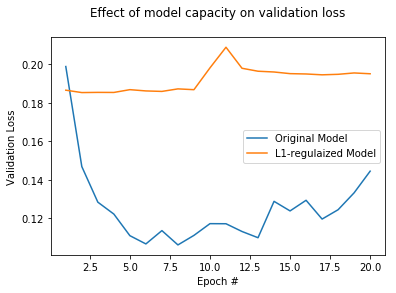

In [87]:
ori_val_Loss = ori_his.history['val_loss']
re_val_Loss = re_his.history['val_loss']

epochs = np.arange(20) + 1
plt.plot(epochs, ori_val_Loss, label='Original Model')
plt.plot(epochs, re_val_Loss, label='L1-regulaized Model')
plt.title("Effect of model capacity on validation loss\n")
plt.xlabel('Epoch #')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

以上例子并未说明添加正则化的模型比没添加的模型更具优秀，而是为了说明，加入正则化，loss会相对更平缓点。

## Method-3. Dropout
Dropout也是一种具有正则性质的手法，是以一定的概率让神经元失活，降低模型的复杂度来达到降低过拟合的程度。
更详细的原理，同学们可以自行查找。

In [88]:
from keras.layers import Dropout

In [89]:
ori_model = Sequential()
ori_model.add(Dense(64, activation='relu', input_shape=(28*28, )))
ori_model.add(Dense(64, activation='relu'))
ori_model.add(Dense(10, activation='softmax'))

ori_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

drop_model = Sequential()
drop_model.add(Dense(64, activation='relu', input_shape=(28*28, )))
drop_model.add(Dropout(0.5))
drop_model.add(Dense(64, activation='relu'))
drop_model.add(Dropout(0.5))
drop_model.add(Dense(10, activation='softmax'))

drop_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
ori_his = ori_model.fit(x=X_train, y=y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), verbose=0)
drop_model = drop_model.fit(x=X_train, y=y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), verbose=0)

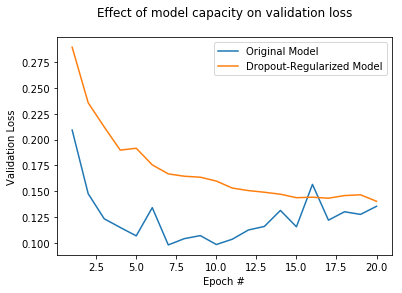

In [91]:
ori_val_Loss = ori_his.history['val_loss']
drop_val_Loss = drop_model.history['val_loss']

epochs = np.arange(20) + 1
plt.plot(epochs, ori_val_Loss, label='Original Model')
plt.plot(epochs, drop_val_Loss, label='Dropout-Regularized Model')
plt.title("Effect of model capacity on validation loss\n")
plt.xlabel('Epoch #')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

以上图可知，dropout的效果非常好，可以很有效的避免了过拟合。

总结，这些都是避免过拟合中较为常见的方法：
* 收集更多的数据
* 降低模型复杂度
* 添加正则项
* 添加dropout
但不仅仅限于这些方法。